In [126]:
# Setup and imports
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from astropy.io import ascii

# Scipy
from scipy.spatial import KDTree
from scipy.special import gamma

# SKLearn
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GMM

# Set up plots
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Ignore deprication warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Problem 1 (Regression and model selection)
Download file ps5_problem1.dat from the Canvas site and conduct a regression analysis with these data. Assume Gaussian errors with a 1-s of 1.3.
- __(a)__ Use different polynomials with degrees from 0 to 10 to fit the data and plot the fits to the data using three of the different models (similar to what is shown in Figure 8.13 of the AstroML book).
- __(b)__ Plot the reduced chi-sq., adjusted coefficient of determination, AIC and BIC as function of the polynomial degree (similar to the lower panel in Figure 8.14 of the AstroML book).
- __(c)__ Conduct a cross-validation analysis similar to that shown in Figure 8.14 of the AstroML book and decide which is the best model to fit the data from your analysis. Explain in detail your analysis and how you came to your conclusion.
Produce learning curves (similar to the ones in Figure 8.15 of the AstroML book) for three of the polynomial fits. Discuss what these plots reveal.

In [172]:
# init some descriptive vars
degree = range(0, 10)

# Read data
data = ascii.read('ps5_problem1.dat')

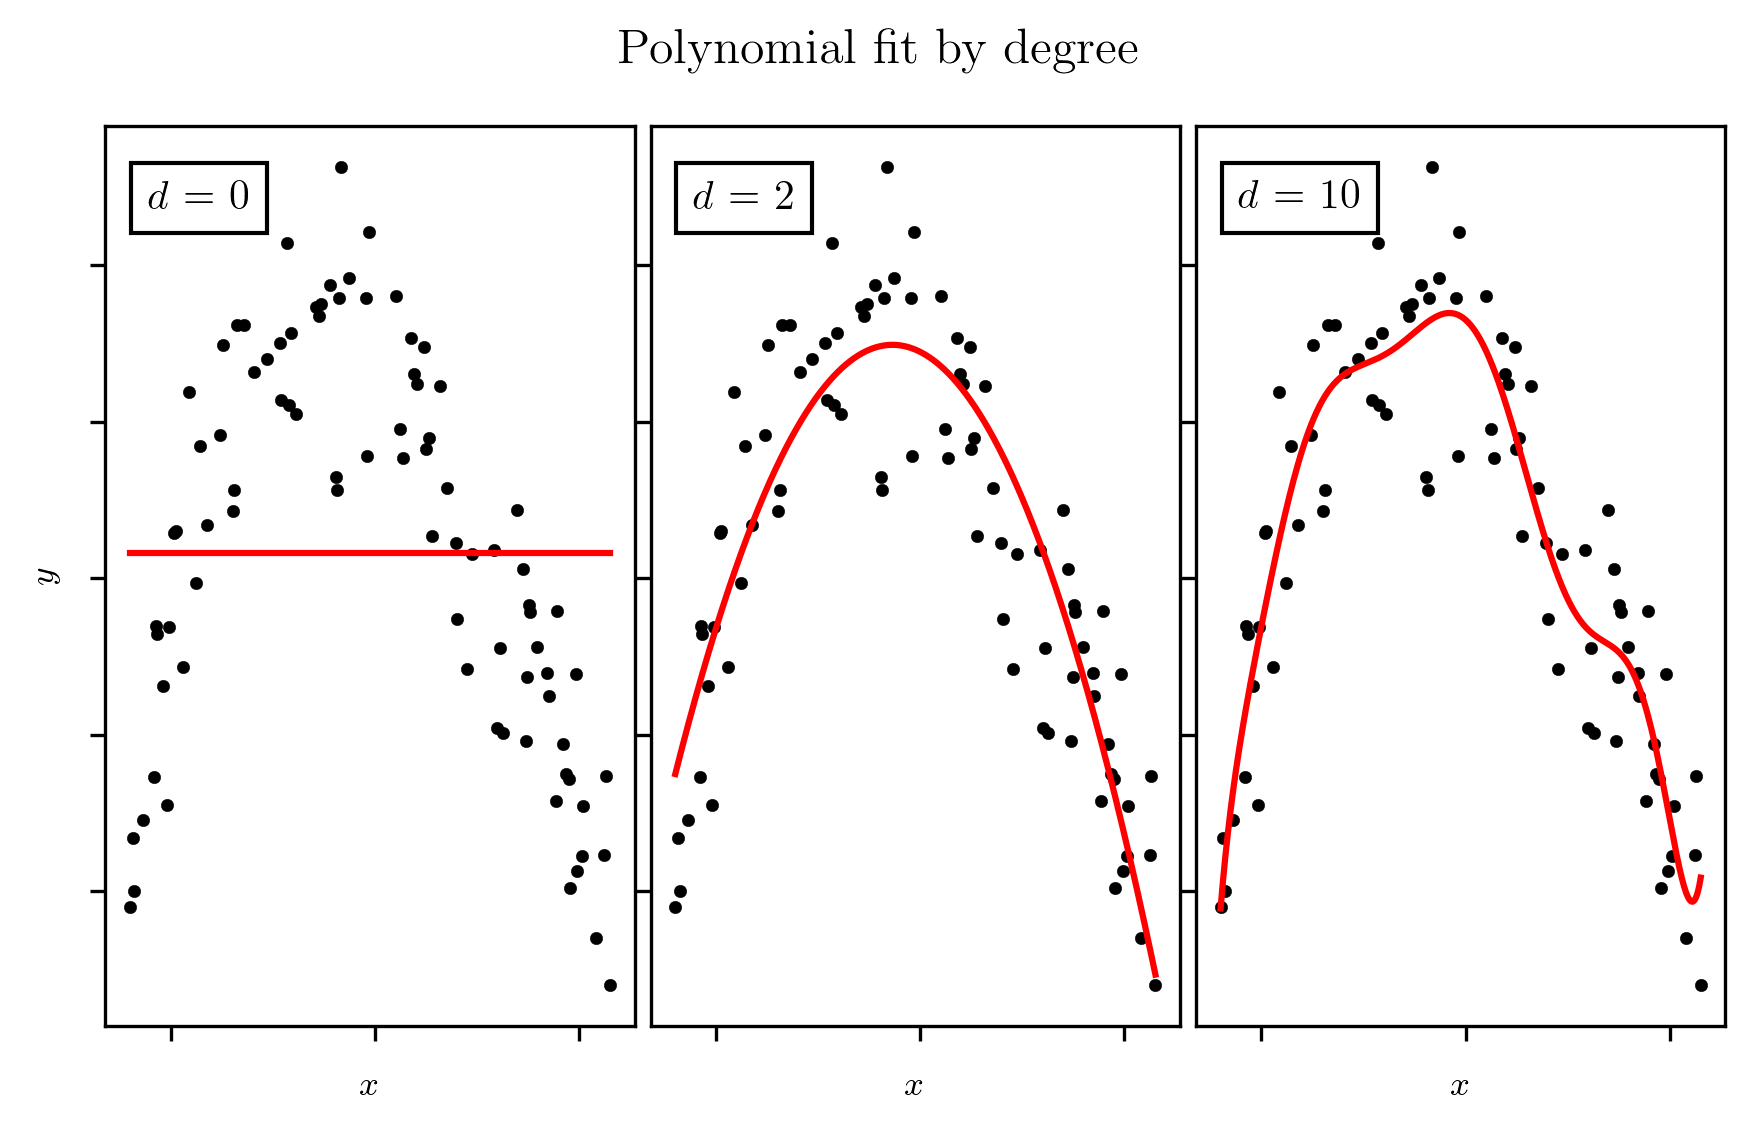

In [173]:
# Part A

# Plot setup
x_fit = np.linspace(np.min(list(data['x'])), np.max(list(data['x'])), 1000)

fig = plt.figure(dpi=300)
fig.suptitle("Polynomial fit by degree")
fig.subplots_adjust(wspace=0.03, bottom=0.15, top=0.9, left=0.07, right=0.97)

for i, deg in enumerate([0, 2, 10]):
    
    # scatterplot of data
    ax = fig.add_subplot(1, 3, 1 + i)
    ax.scatter(list(data['x']), list(data['y']), marker = '.', color = 'black', lw=0.1)
    
    # polynomial fit
    p = np.polyfit(list(data['x']), list(data['y']), deg)
    y_fit = np.polyval(p, x_fit)
    
    # plot polynomial
    ax.plot(x_fit, y_fit, color = 'red')
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    if (i == 0):
        ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.94, "$d$ = %i" % deg, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w', pad=4))
    
plt.show()

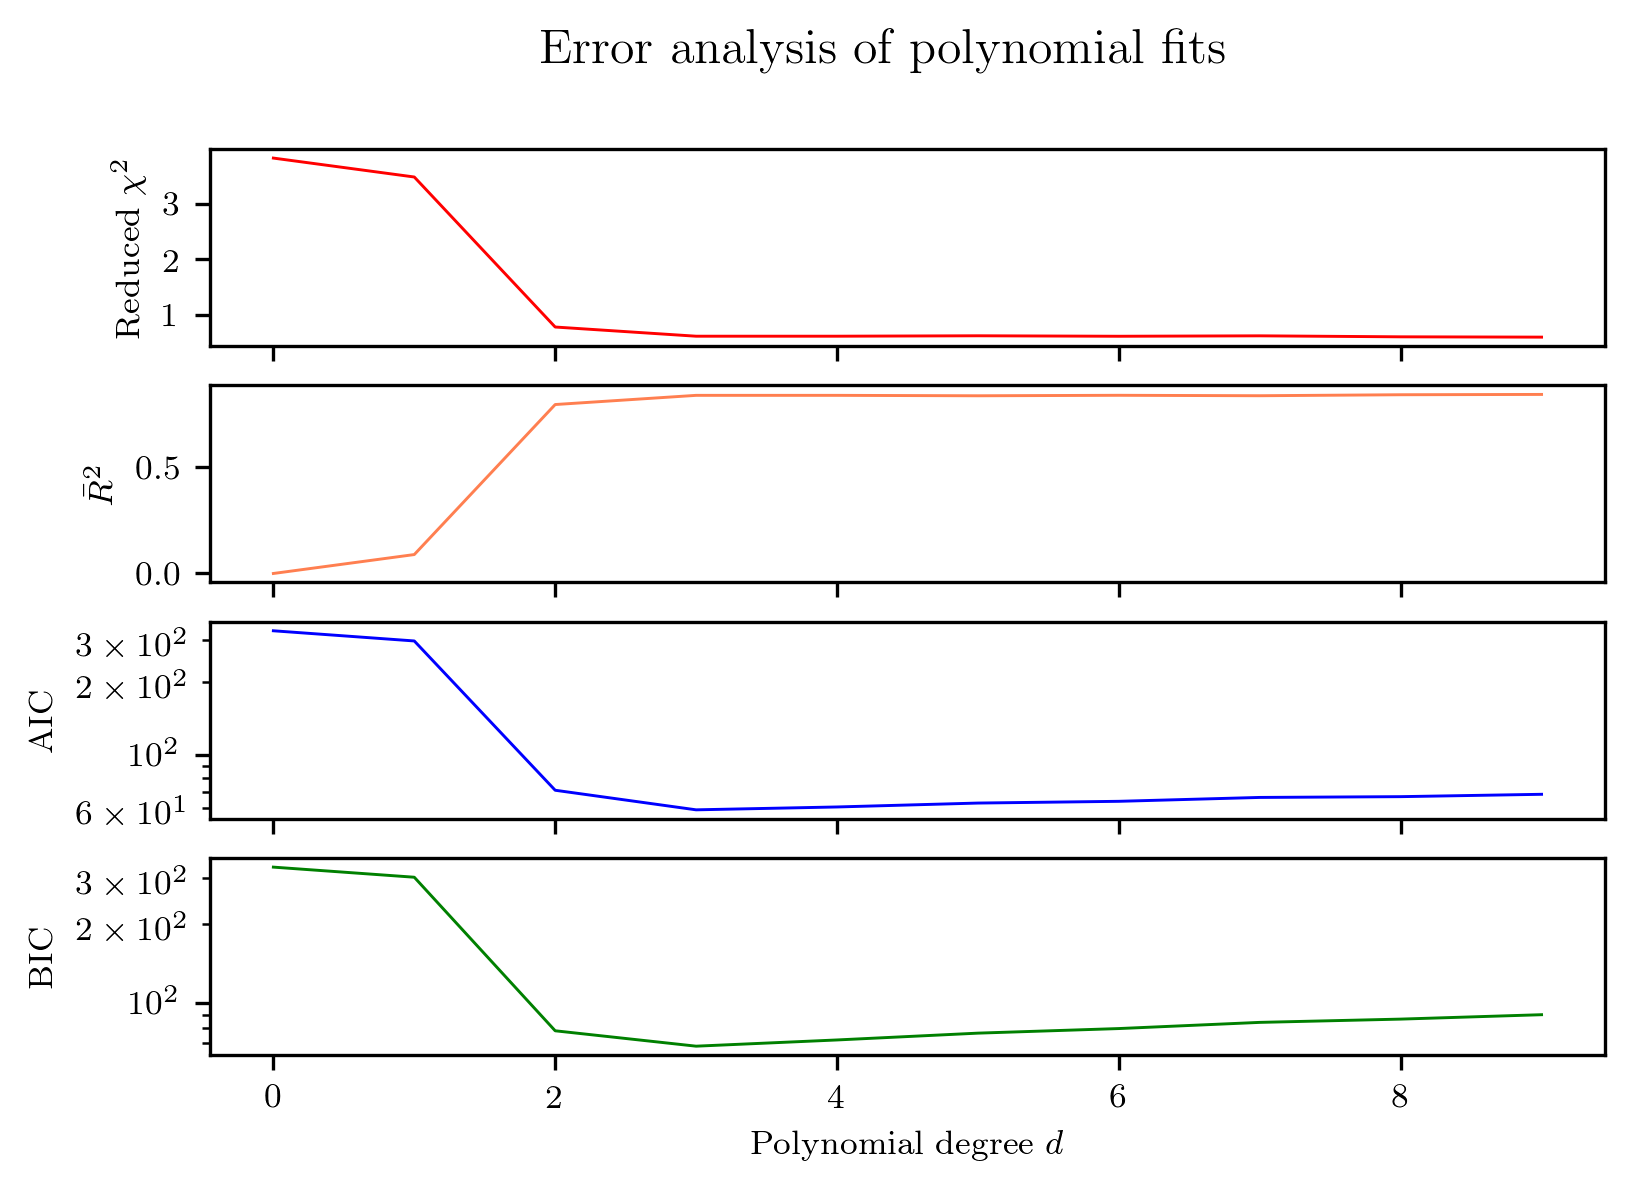

In [174]:
# Part B

# Set up plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, dpi=300)
fig.suptitle("Error analysis of polynomial fits");

# Statistics
chi = []
adc = []
bic = []
aic = []

# Errors
sigma = 1.3

# Calculate each statistic
for deg in degree:
    
    # Get polynomial fit
    p = np.polyfit(list(data['x']), list(data['y']), deg)
    y_fit = np.polyval(p, x_fit)
    
    # Calculate chi_squared
    cs = 0
    for i, o_i in enumerate(list(data['y'])):
        cs += (o_i - np.polyval(p, list(data['x'])[i]))**2 / sigma**2
    chi.append(cs / (len(list(data['x'])) - deg - 1))
    
    # Adjusted R^2
    ss_tot = sum([(y_i - np.mean(list(data['y'])))**2 for y_i in list(data['y'])])
    ss_res = sum([(y - m)**2 for y,m in zip(list(data['y']), np.polyval(p, list(data['x'])))])
    arsq = 1 - ss_res / ss_tot
    arsq = 1 - (1 - arsq)*(len(list(data['x'])) - 1)/(len(list(data['x'])) - 1 - deg)
    adc.append(arsq)
    
    # Akaike Criterion
    aici = 2*(deg + 1) + cs + (2*(deg+1)**2 + 2*(deg+1))/float(len(list(data['x'])) - deg - 1)
    aic.append(aici)
    
    # Bayesian Criterion
    bici = math.log(len(list(data['x'])))*(deg + 1) + cs
    bic.append(bici)
    

ax1.plot(degree, chi, color='red', lw=0.7);
ax1.set_ylabel("Reduced $\chi^2$");

ax2.plot(degree, adc, color='coral', lw=0.7);
ax2.set_ylabel("$\\bar{R}^2$");

ax3.plot(degree, aic, color='blue', lw=0.7);
ax3.set_ylabel("AIC");
ax3.set_yscale("log");

ax4.plot(degree, bic, color='green', lw=0.7);
ax4.set_ylabel("BIC");
ax4.set_yscale("log");

ax4.set_xlabel("Polynomial degree $d$");

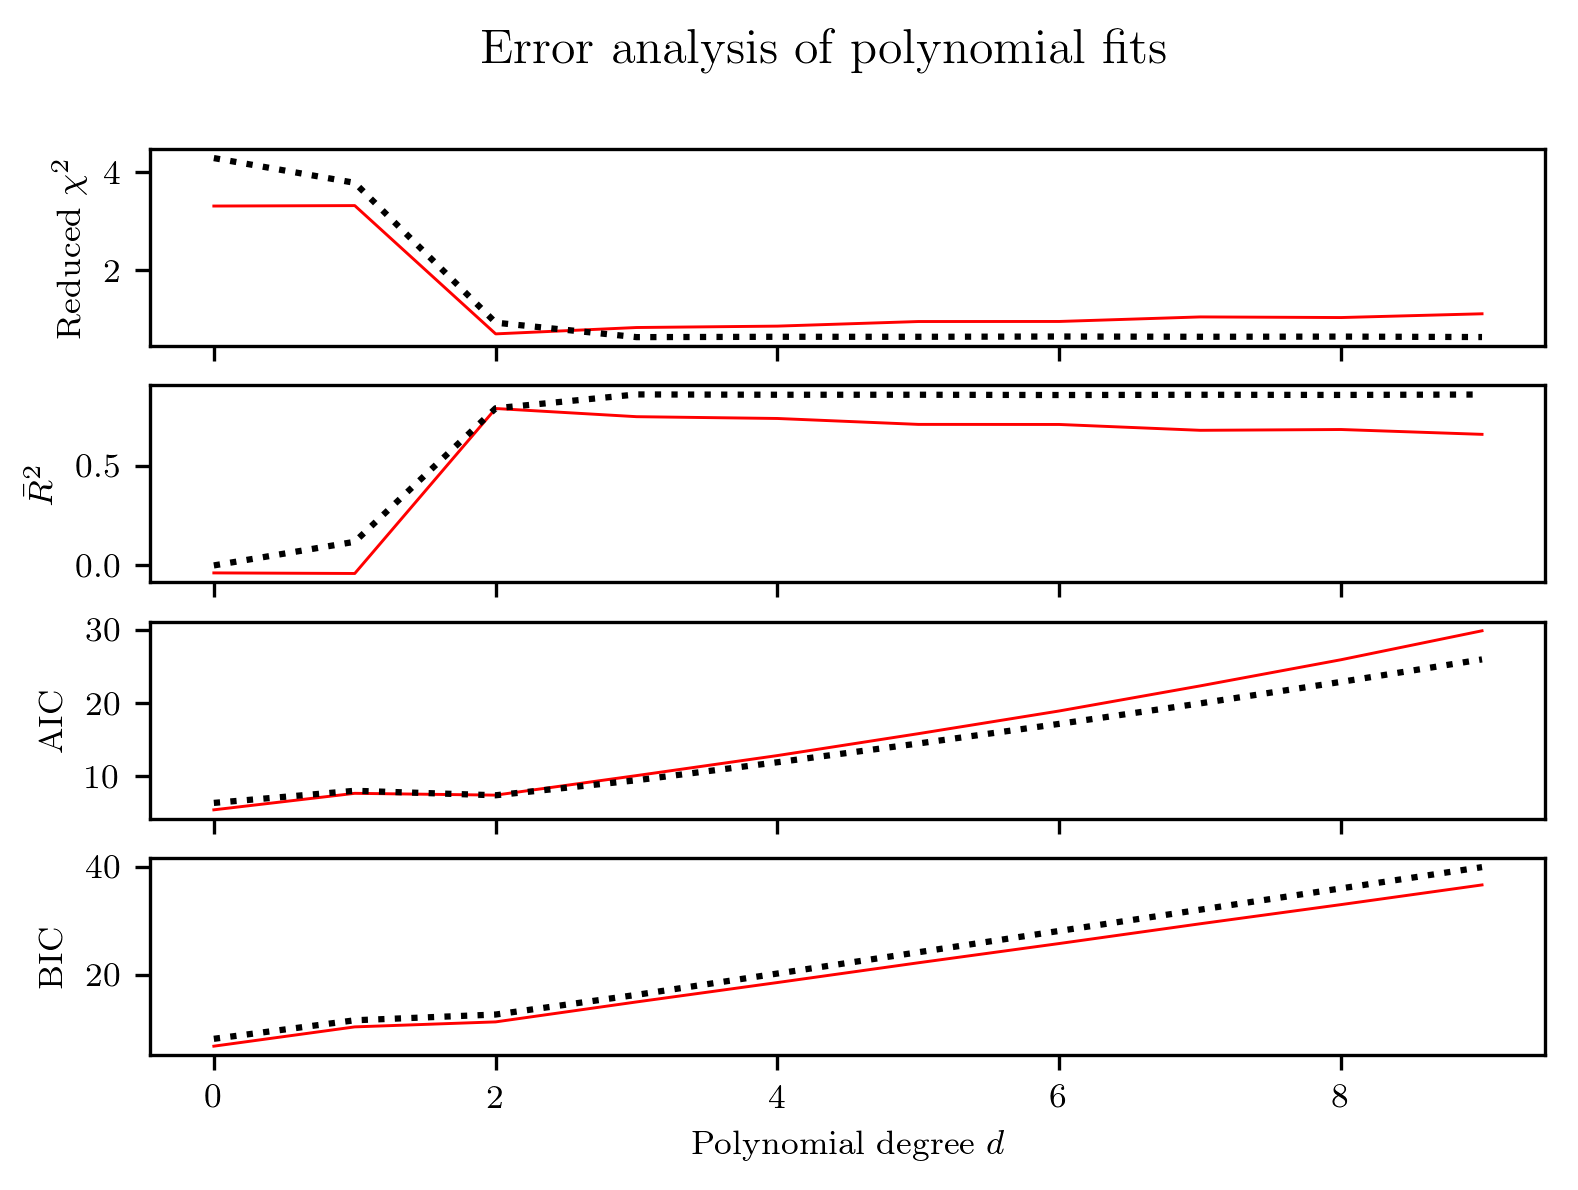

In [102]:
# Split data into training and CV
x_train, x_cv, y_train, y_cv = train_test_split(list(data['x']), list(data['y']), test_size = 0.4)

# Training Statistics
test_chi = []
test_adc = []
test_bic = []
test_aic = []

# CV Statistics
chi = []
adc = []
bic = []
aic = []

for deg in degree:
    
    # Fit a polynomial to our training data
    p = np.polyfit(x_train, y_train, deg)
    
    # Calculate Training stats
    # Calculate chi_squared
    model = np.polyval(p, x_train)
    cs = sum([(m - y)**2 / sigma**2 for m,y in zip(model, y_train)]) / float(len(x_train) - deg - 1)
    test_chi.append(cs)
    
    # Adjusted R^2
    ss_tot = sum([(y_i - np.mean(y_train))**2 for y_i in y_train])
    ss_res = sum([(y - m)**2 for y,m in zip(y_train, np.polyval(p, x_train))])
    
    arsq = 1 - ss_res / ss_tot
    arsq = 1 - (1 - arsq)*(len(x_train) - 1)/(len(x_train) - 1 - deg)
    test_adc.append(arsq)
    
    # Akaike Criterion
    aici = 2*(deg + 1) + cs + (2*(deg+1)**2 + 2*(deg+1))/float(len(x_train) - deg - 1)
    test_aic.append(aici)
    
    # Bayesian Criterion
    bici = math.log(len(x_train))*(deg + 1) + cs
    test_bic.append(bici)
    
    # Calculate CV stats
    # Calculate chi_squared
    model = np.polyval(p, x_cv)
    cs = sum([(m - y)**2 / sigma**2 for m,y in zip(model, y_cv)]) / float(len(x_cv) - deg - 1)
    chi.append(cs)
    
    # Adjusted R^2
    ss_tot = sum([(y_i - np.mean(y_cv))**2 for y_i in y_cv])
    ss_res = sum([(y - m)**2 for y,m in zip(y_cv, np.polyval(p, x_cv))])
    
    arsq = 1 - ss_res / ss_tot
    arsq = 1 - (1 - arsq)*(len(x_cv) - 1)/(len(x_cv) - 1 - deg)
    adc.append(arsq)
    
    # Akaike Criterion
    aici = 2*(deg + 1) + cs + (2*(deg+1)**2 + 2*(deg+1))/float(len(x_cv) - deg - 1)
    aic.append(aici)
    
    # Bayesian Criterion
    bici = math.log(len(x_cv))*(deg + 1) + cs
    bic.append(bici)
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, dpi=300)
fig.suptitle("Error analysis of polynomial fits");
ax1.plot(degree, chi, color='red', lw=0.7);
ax1.plot(degree, test_chi, color = 'black', linestyle = ':')
ax1.set_ylabel("Reduced $\chi^2$");

ax2.plot(degree, adc, color='red', lw=0.7);
ax2.plot(degree, test_adc, color = 'black', linestyle = ':')
ax2.set_ylabel("$\\bar{R}^2$");

ax3.plot(degree, aic, color='red', lw=0.7);
ax3.plot(degree, test_aic, color = 'black', linestyle = ':')
ax3.set_ylabel("AIC");
# ax3.set_yscale("log");

ax4.plot(degree, bic, color='red', lw=0.7);
ax4.plot(degree, test_bic, color = 'black', linestyle = ':')
ax4.set_ylabel("BIC");
# ax4.set_yscale("log");

ax4.set_xlabel("Polynomial degree $d$");

Based upon the above plots, I'd say that the best fit for our data comes from a degree 2 (quadratic) polynomial. There are several reasons for this:
- In part (b), we found that the reducted $\chi^2$ is quite low for $d = 2$, and really starts to level off for $d > 2$, indicating that adding a degree of freedom to our polynomial doesn't really improve the fit very much after a quadratic fit.
- We also found a similar thing happen with the adjusted $R^2$ value, where it levels off after $d = 2$.
- The AIC and BIC both indicate that polynomials of degree $2$ or $3$ would be good fits (actually favoring the cubic polynomials in this case).
- When we run a cross-validation test on our fits, we actually find that reduced $\chi^2$ is *fully minimized* (and adjusted $R^2$ *fully maximized*) when $d = 2$ for the cross validation data.

In general, we want to select a fit that has the following properties:
- A high adjusted $R^2$ value; this indicates that our model explains a very high proportion of the data's variation.
- A low reduced $\chi^2$ value; this indicates low residuals and not too many parameters.
- Low AIC and BIC values; these give a penalty for having too many parameters in our model, so we don't over fit our data. Too high a value means that we either aren't explaining very much of our data or we have too many parameters in our model which really aren't helping all that much.

Overall, these 4 plots (really 8 plots) show that while increasing the degree of the polynomial does help us explain more of the variation in the data, we very quickly start overfitting to the point where the fit no-longer has meaningful predictive value; this can be seen by looking at the plot for $d=10$ in part (a).

# Problem 2: KDE and clustering (25 ptgs.)
In the following problem you will use the COMBO-17 (Classifying Objects by Medium-Band Observations in 17 filters) dataset from Wolf et al. 2004, A&A, 421, 913 (see: http://adsabs.harvard.edu/abs/2004A%26A...421..913W), which I have uploaded to the Canvas site. This is the first public catalogue of a large dataset (with 63,501 objects) with brightness measurements in 17 bands. Note that the Sloan Digital Sky Survey provides a much larger dataset, by 4 to 5 orders of magnitudes, but with measurements in “only” five bands. Hence, the COMBO-17 dataset has much less objects, but many more dimensions, than the SDSS dataset. For this problem we are interested in galaxies with redshift (z) less than 0.3, and the absolute magnitude values of these low-redshift galaxies in the Johnson B-band and the UV band at 280nm.
- __a)__ Make a color-magnitude (i.e., M280 - MB vs. MB) plot for these low-z galaxies.
- __b)__ Use KDE and nearest-neighbor density estimation to plot the data. Show these two plots and compare them with the original plot that shows the individual galaxies (from part a). Explain how you chose your kernel bandwidth (which should be based in oe of the methods we discussed in class) for the KDE process and value of K for the nearest-neighbor density estimations. Explain what you see in these plots in words. You should be able to see the so-called red sequence (in the upper left part of the plots) and the so-called blue sequence (in the lower right part of the plots) as two (more or less) distinct clusters of points.
- __c)__ Conduct a K-means cluster analysis of the color-magnitude points. Use one of the ways discussed in class to decide on the number of clusters (i.e., K number in the K-means cluster analysis). Show a new plot of the magnitude-color diagram where you identify the different cluster members with different symbols or colors.
- __d)__ Conduct a mean shift clustering analysis of the data. Explain how you selected the kernel width. Show a new plot of the magnitude-color diagram where you identify the different cluster members with different symbols or colors. Compare your findings with those from the K-means analysis of part c.
- __e)__ Conduct an agglomerative hierarchical clustering analysis on the color-magnitude plot. Show the dendogram and decide where you think it makes the most sense (scientifically) to “cut the tree”. How many clusters do you get? Show a new plot of the magnitude-color diagram where you identify the different cluster members with different symbols or colors. Identify these clusters in the dendogram diagram. How does your answer compare to the other two clustering algorithms?
- __f)__ Conduct a Gaussian mixture model clustering analysis. Discuss, in detail, how you choose the number of Gaussians in your model. Compare the results with the other clustering algorithms.

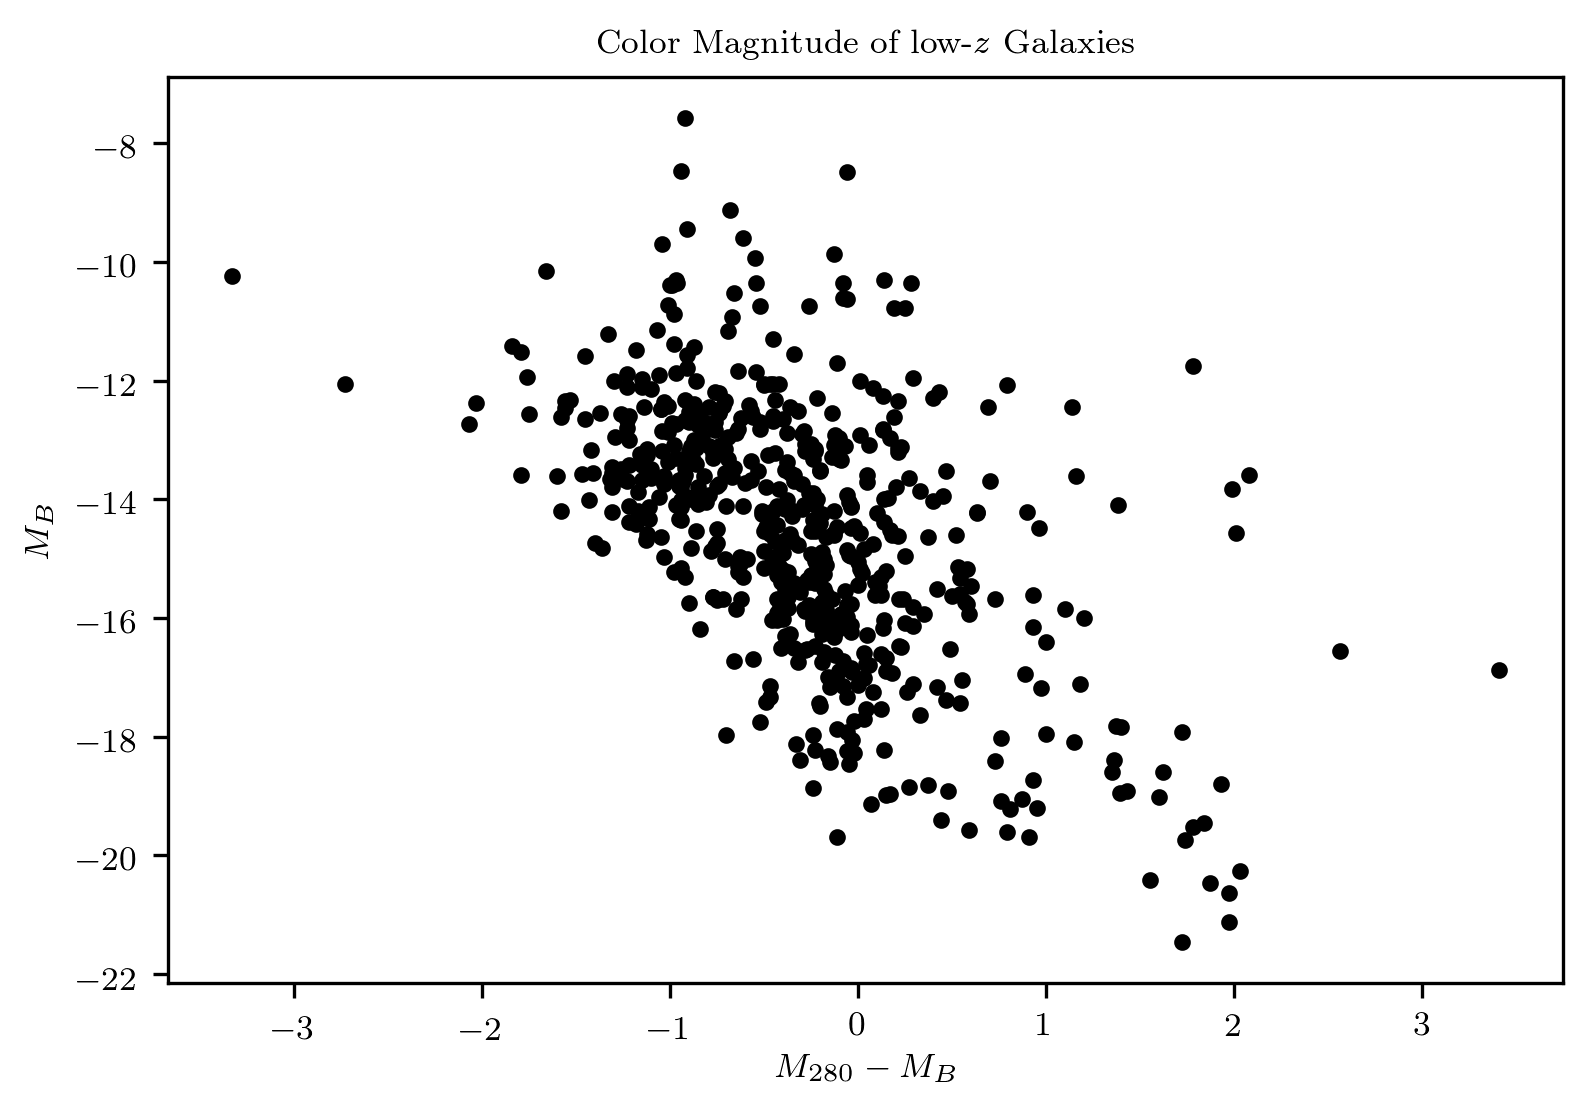

In [151]:
# Part A

# Import data
data = ascii.read('fixed_COMBO17.dat')

# Exclude data with high redshift
rem_rows = []
for i, z in enumerate(data['Mcz']):
    if z > 0.3:
        rem_rows.append(i)
data.remove_rows(rem_rows)

# Reduce data to what we care about
BV_Data = np.array([ M - B for M,B in zip(list(data['S280MAG']), list(data['BjMAG'])) ])
B_Data = np.array(data['BjMAG'])

# Plot color magnitude diagram
plt.figure(dpi = 300)
plt.scatter(BV_Data, B_Data,
           color = 'black', marker = '.')
plt.title("Color Magnitude of low-$z$ Galaxies");
plt.ylabel("$M_B$");
plt.xlabel("$M_{280} - M_B$");
# plt.gca().invert_yaxis();

In [55]:
# K-Nearest Neighbors
def knn_density(data, x, k):
    """
    Implements the K-Nearest Neihbors algorithm via scipy
    
    data:     Input data (n points by m dimensions)
    
    x:        Density estimation points (l points in m dimensions)
    
    k:        # of neighbors
    """
    
    kdt = KDTree(data)
    d = kdt.query(x, k = k)[0][:, -1]
    n = np.shape(data)[1]
    v = np.pi**(n / 2.0) * gamma(n / 2.0 + 1) * d**n
    
    return k / v


In [134]:
# Part B

# Slice data into x-y pairs
HR_Data = []
for BV, B in zip(BV_Data, B_Data):
    HR_Data.append([BV, B])

# Create Grid
X, Y = np.meshgrid(np.linspace(np.min(BV_Data), np.max(BV_Data), 200),
                   np.linspace(np.min(B_Data), np.max(B_Data), 200))
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Estimate Bandwidth using Gridsearch
gs = GridSearchCV(KernelDensity(),
                 {'bandwidth' : np.linspace(0.1, 2, 50)}, cv = 30)
gs.fit(HR_Data)
bandwidth = gs.best_params_["bandwidth"]

0.37142857142857144


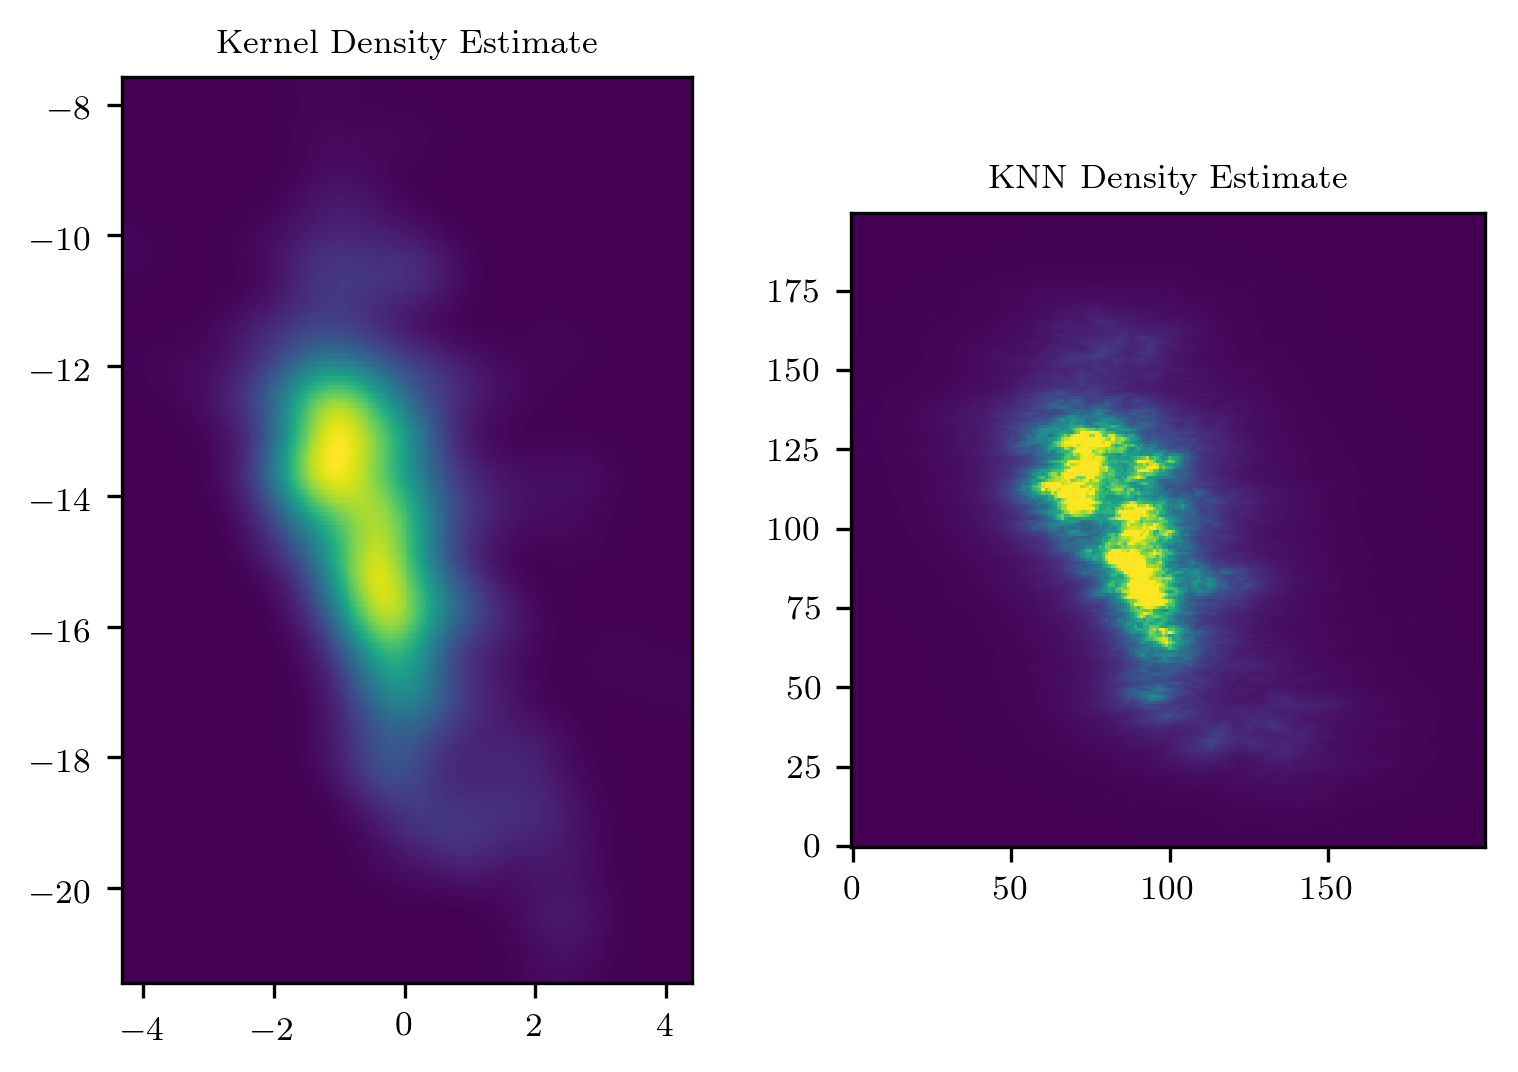

In [150]:
# KDE Density estimate
kde = KernelDensity(bandwidth = bandwidth, kernel = 'gaussian').fit(HR_Data)
dens_kde = kde.score_samples(grid).reshape(X.shape)

# KNN Density
dens_knn = knn_density(HR_Data, grid, k=11).reshape(X.shape)

# Plot Density Estimates
fig, (ax_1, ax_2) = plt.subplots(nrows = 1, ncols = 2, dpi = 300);
ax_1.imshow(np.exp(dens_kde), origin = 'lower',
           extent = [np.min(BV_Data) - 1,
                     np.max(BV_Data) + 1,
                     np.min(B_Data),
                     np.max(B_Data)]);
ax_1.set_title("Kernel Density Estimate");
ax_1.set_aspect("equal");

ax_2.imshow(dens_knn,
            origin = 'lower',
            vmin = np.percentile(dens_knn, 5),
            vmax = np.percentile(dens_knn, 99));
ax_2.set_title("KNN Density Estimate");
ax_2.set_aspect("equal");

We use a gridsearch to find the optimal value for the bandwidth, and then use that value to get a kernel density estimate for our data. The KDE estimate for the data looks (understandably) much smoother than the KNN density estimate, but both plots show a similar distribution. It looks like the red sequence and blue sequence are very much visible on the KNN plot, along with either one or two other clusters in the middle-right of the plot. The density plots do look a lot alike the discrete plot of the data which generated it (modulo a flip in the y-axis for convention), although the clustering is perhaps more apparent in the density plots than in the data themselves.

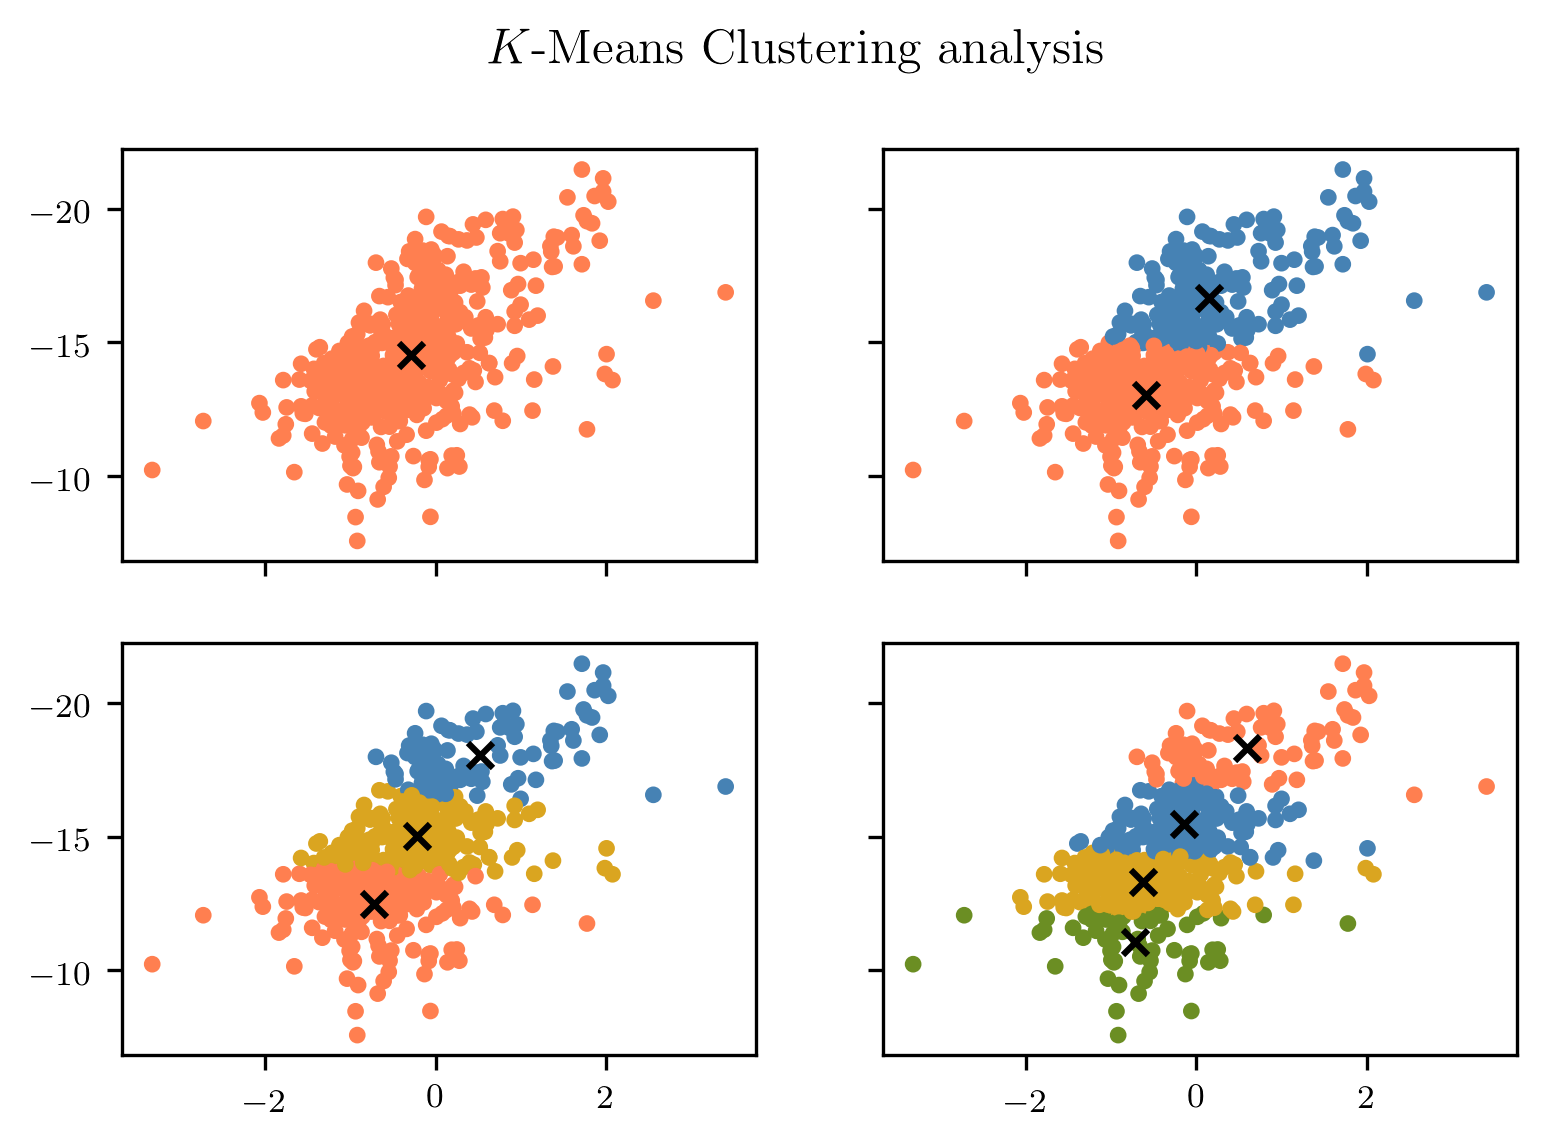

In [161]:
# Part C

# Set up plots
fig, ((ax_1, ax_2), (ax_3, ax_4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey = True, dpi=300)
fig.suptitle("$K$-Means Clustering analysis")
axes = [ax_1, ax_2, ax_3, ax_4]

inertia = []

for k in range(1, 5):
    
    # Calculate cluster
    kmeans = KMeans(n_clusters = k)
    kmeans = kmeans.fit(HR_Data)
    labels = kmeans.predict(HR_Data)
    C = kmeans.cluster_centers_
    
    # Find distance
    inertia.append(kmeans.inertia_)
    
    # Plot cluster & center
    colors = [['coral', 'steelblue', 'goldenrod', 'olivedrab'][i] for i in labels]
    axes[k - 1].scatter(BV_Data, B_Data, c = colors, marker = '.')
    axes[k - 1].scatter(C[:, 0], C[:, 1], color = 'black', marker = 'x')

plt.gca().invert_yaxis();

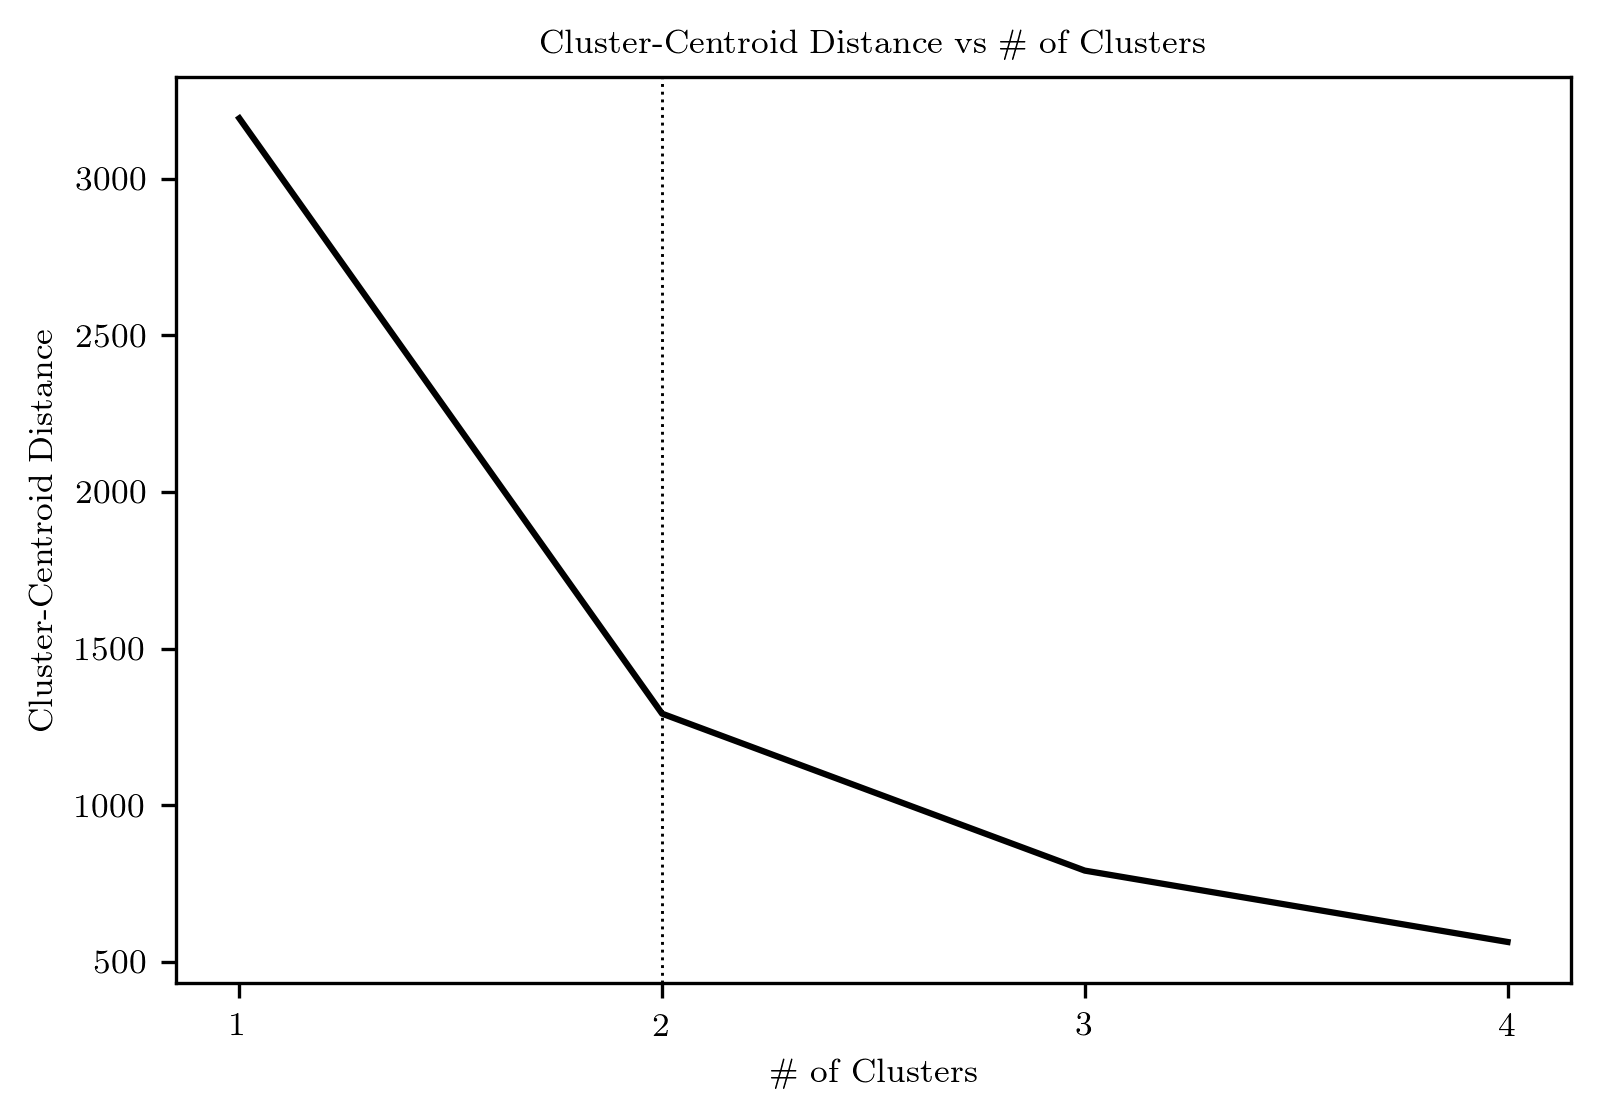

In [170]:
plt.figure(dpi = 300);
plt.plot(range(1,5), inertia, color = 'black');
plt.ylabel("Cluster-Centroid Distance");
plt.xlabel("\# of Clusters");
plt.axvline(x = 2.0, linestyle = ':', lw = 0.7, color = 'black');
plt.title("Cluster-Centroid Distance vs \# of Clusters");
plt.xticks(np.arange(1,5));

Using the elbow method, we find that for our $K$-Means cluster analysis the optimum number of clusters is 2.

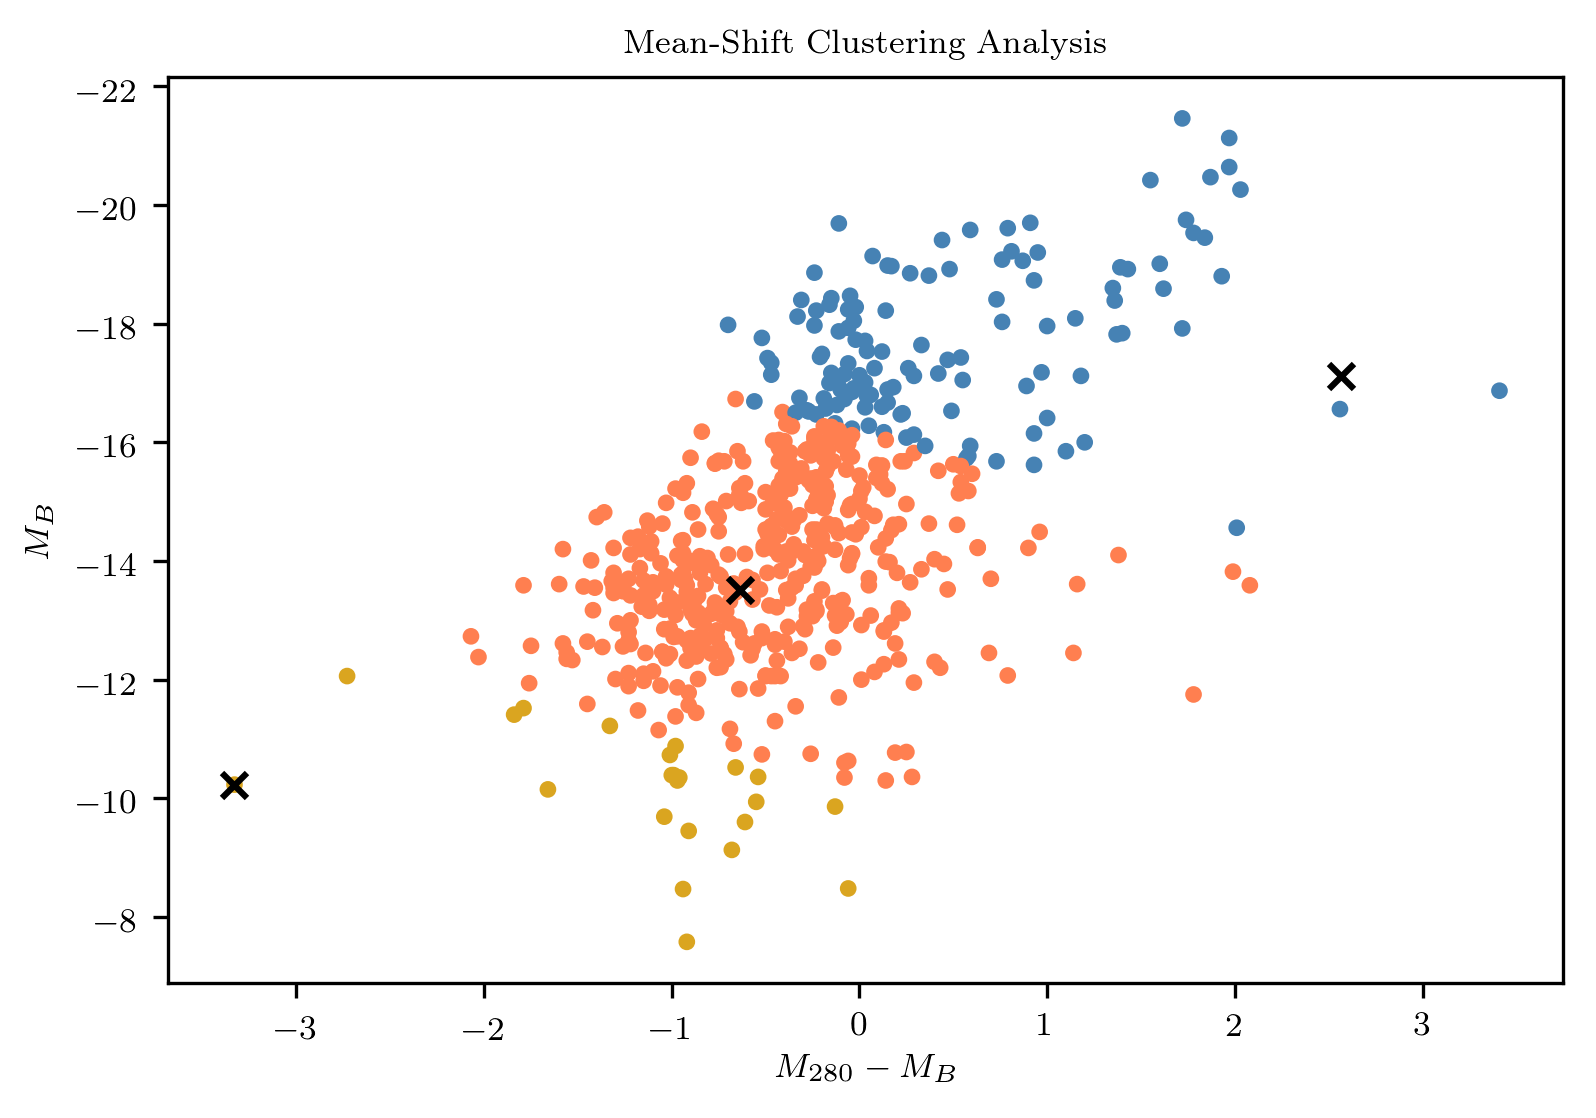

In [155]:
# Part D

# Estimate bandwidth and preform cluster analysis
bandwidth = estimate_bandwidth(HR_Data, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth = bandwidth, bin_seeding=True)
ms.fit(HR_Data)
labels = ms.labels_
C = ms.cluster_centers_
n_clusters_ = len(np.unique(labels))

# Plot clusters & centers
colors = [['coral', 'steelblue', 'goldenrod', 'olivedrab'][i] for i in labels]
plt.figure(dpi = 300);
plt.scatter(BV_Data, B_Data, c = colors, marker = '.');
plt.scatter(C[:, 0], C[:, 1], color = 'black', marker = 'x');
plt.title("Mean-Shift Clustering Analysis");
plt.ylabel("$M_B$");
plt.xlabel("$M_{280} - M_B$");
plt.gca().invert_yaxis();

The mean-shift result is notable here I think for two reasons; firstly, it produces a different number of clusters than any other algorithm, and the clusters it does produce are different; specifically, the cluster in the lower left of the graph is very sparsely populated, with a centroid far removed from the rest of the data. Same goes for the top cluster.

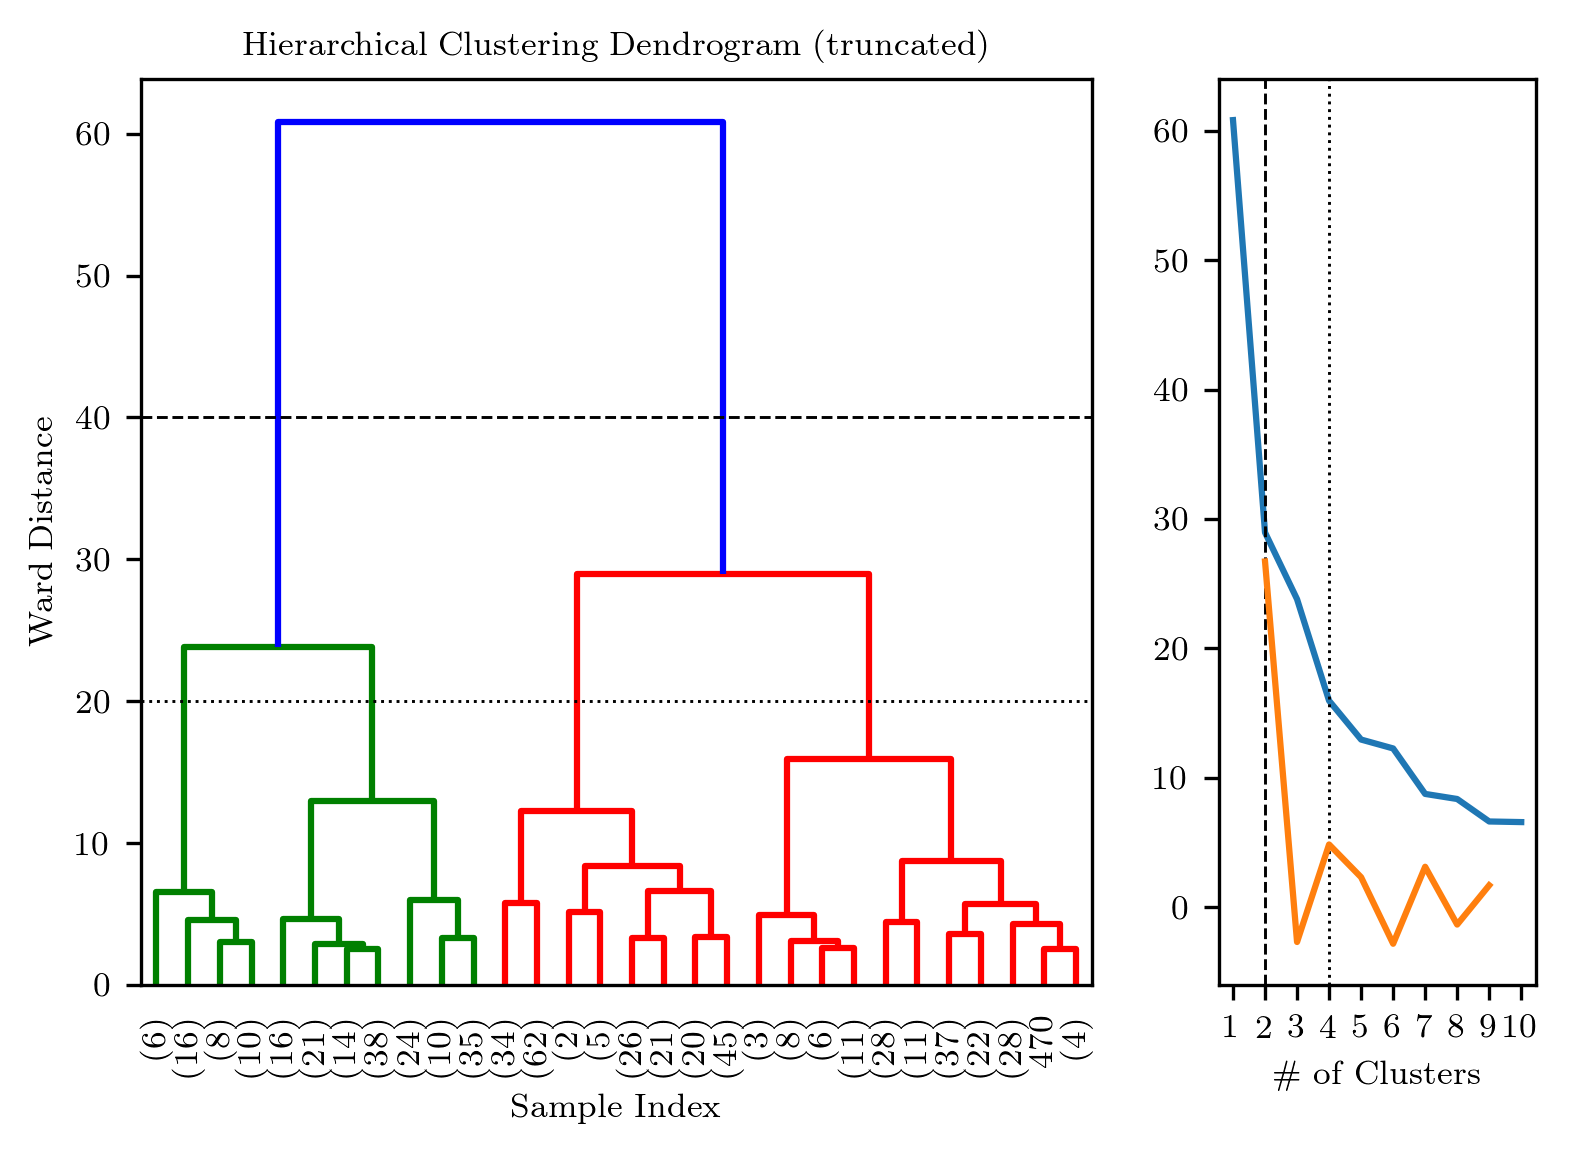

In [69]:
# Part E

# Preform Agg. Analysis
Z = linkage(HR_Data, 'ward')

# Plot Configure Plots
fig = plt.figure(dpi=300)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
ax_1 = plt.subplot(gs[0])

# Plot Dendogram
dendrogram(Z, truncate_mode='lastp', leaf_rotation=90., leaf_font_size=8.)
ax_1.set_title('Hierarchical Clustering Dendrogram (truncated)')
ax_1.set_xlabel('Sample Index')
ax_1.set_ylabel('Ward Distance')
ax_1.axhline(y=20, color = 'k', linestyle = ':', lw = 0.7);
ax_1.axhline(y=40, color = 'k', linestyle = '--', lw = 0.7);

# Plot Elbow Diagram
ax_2 = plt.subplot(gs[1])
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
ax_2.plot(idxs, last_rev);
ax_2.set_xlabel('\# of Clusters');
ax_2.set_xticks(np.arange(1,11));
ax_2.axvline(x = 4, linestyle = ':', lw = 0.7, color = 'k');
ax_2.axvline(x = 2, linestyle = '--', lw = 0.7, color = 'k');

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
ax_2.plot(idxs[:-2] + 1, acceleration_rev);

We used the 'elbow method' to try and gauge where we should cut the dendogram to best estimate the clusters in our data. A distance-vs-cluster plot indicates that the best places to cut our tree would be at either 2 or 4 clusters (2 has the highest second derivative, but to my eyes 4 looks more like the elbow point of the graph).

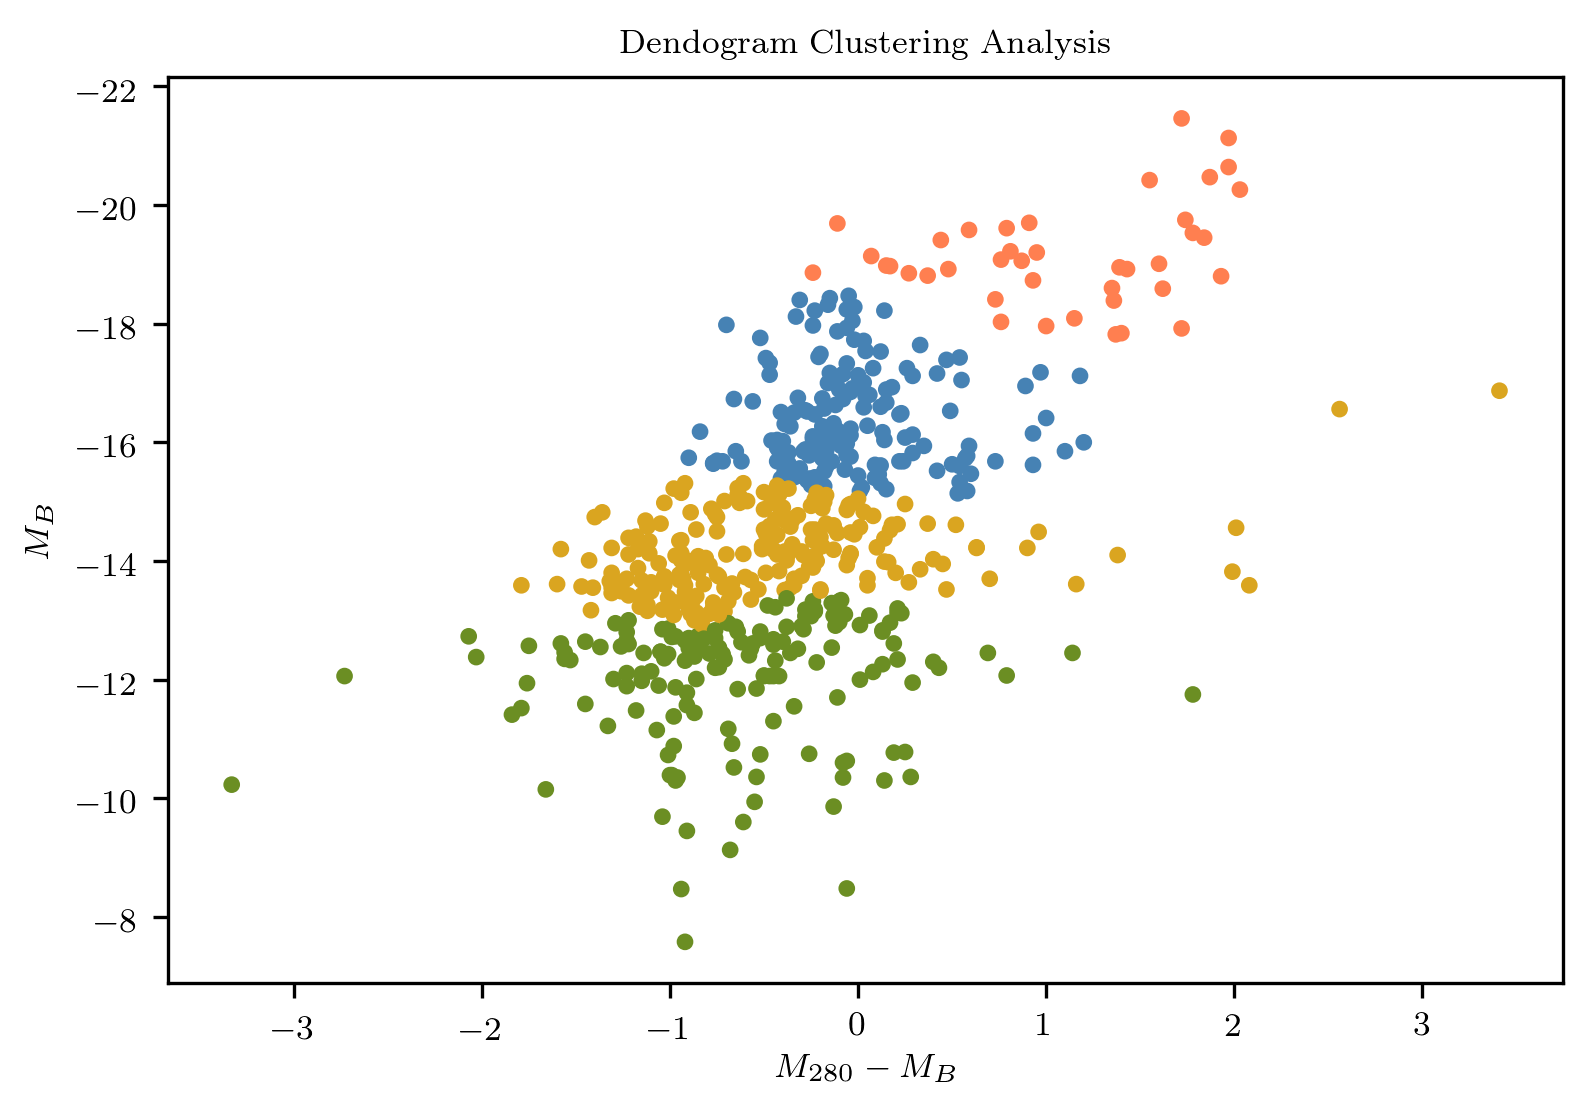

In [123]:
# Find k = 4 clusters in our data from the dendogram distances
dend_clusters = fcluster(Z, 4, criterion = 'maxclust')

# Plot by cluster
colors = [['coral', 'steelblue', 'goldenrod', 'olivedrab'][i - 1] for i in dend_clusters]
plt.figure(dpi = 300)
plt.scatter(BV_Data, B_Data, c = colors, marker = '.');
plt.title("Dendogram Clustering Analysis");
plt.ylabel("$M_B$");
plt.xlabel("$M_{280} - M_B$");
plt.gca().invert_yaxis();

This clustering looks a little different than the mean-shift clustering result, but quite similar to the $K$-Means clustering example. The clusters are stratified horizontally and *rouhgly* evenly distributed throughout the data's vertical axis.

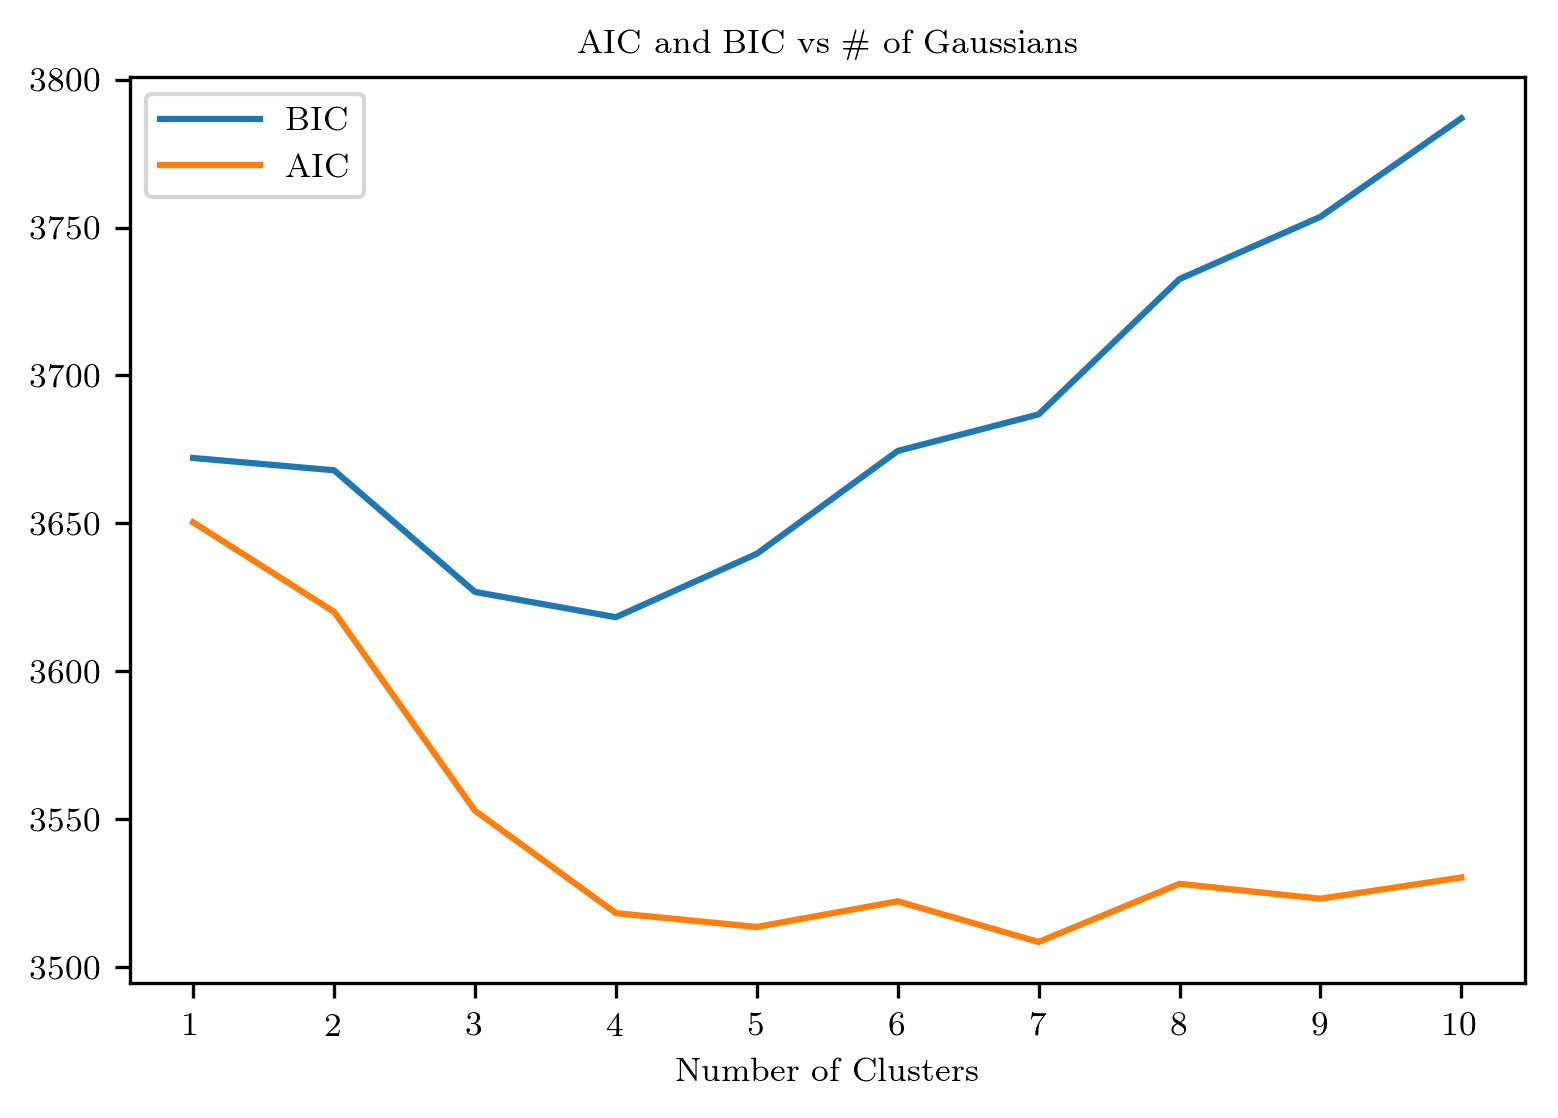

In [116]:
# Part F
# Process is based on the Python Data Science Handbook

# Calculate AIC/BIC for different # of Gaussian Clusters
n_clusters = np.arange(1, 11)
HR_Data = np.array([np.array(m) for m in HR_Data])
models = [GMM(n, covariance_type='full', random_state=0).fit(HR_Data)
          for n in n_clusters]
labels = [m.predict(HR_Data) for m in models]

# Plot AIC/BIC
plt.figure(dpi=300)
plt.plot(n_components, [m.bic(HR_Data) for m in models], label='BIC');
plt.plot(n_components, [m.aic(HR_Data) for m in models], label='AIC');
plt.legend(loc='best');
plt.xlabel("Number of Clusters");
plt.xticks(n_clusters);
plt.title("AIC and BIC vs \# of Gaussians");

We use the AIC and BIC to get an estimate of what the optimum number of clusters should be in our model. We want to select a model which has a low AIC/BIC value relative to the other models in contention. The BIC indicates that $n = 4$ is the best estimate, while the AIC indicates that $n = 4,5,7$ would all be good numbers of clusters to use.

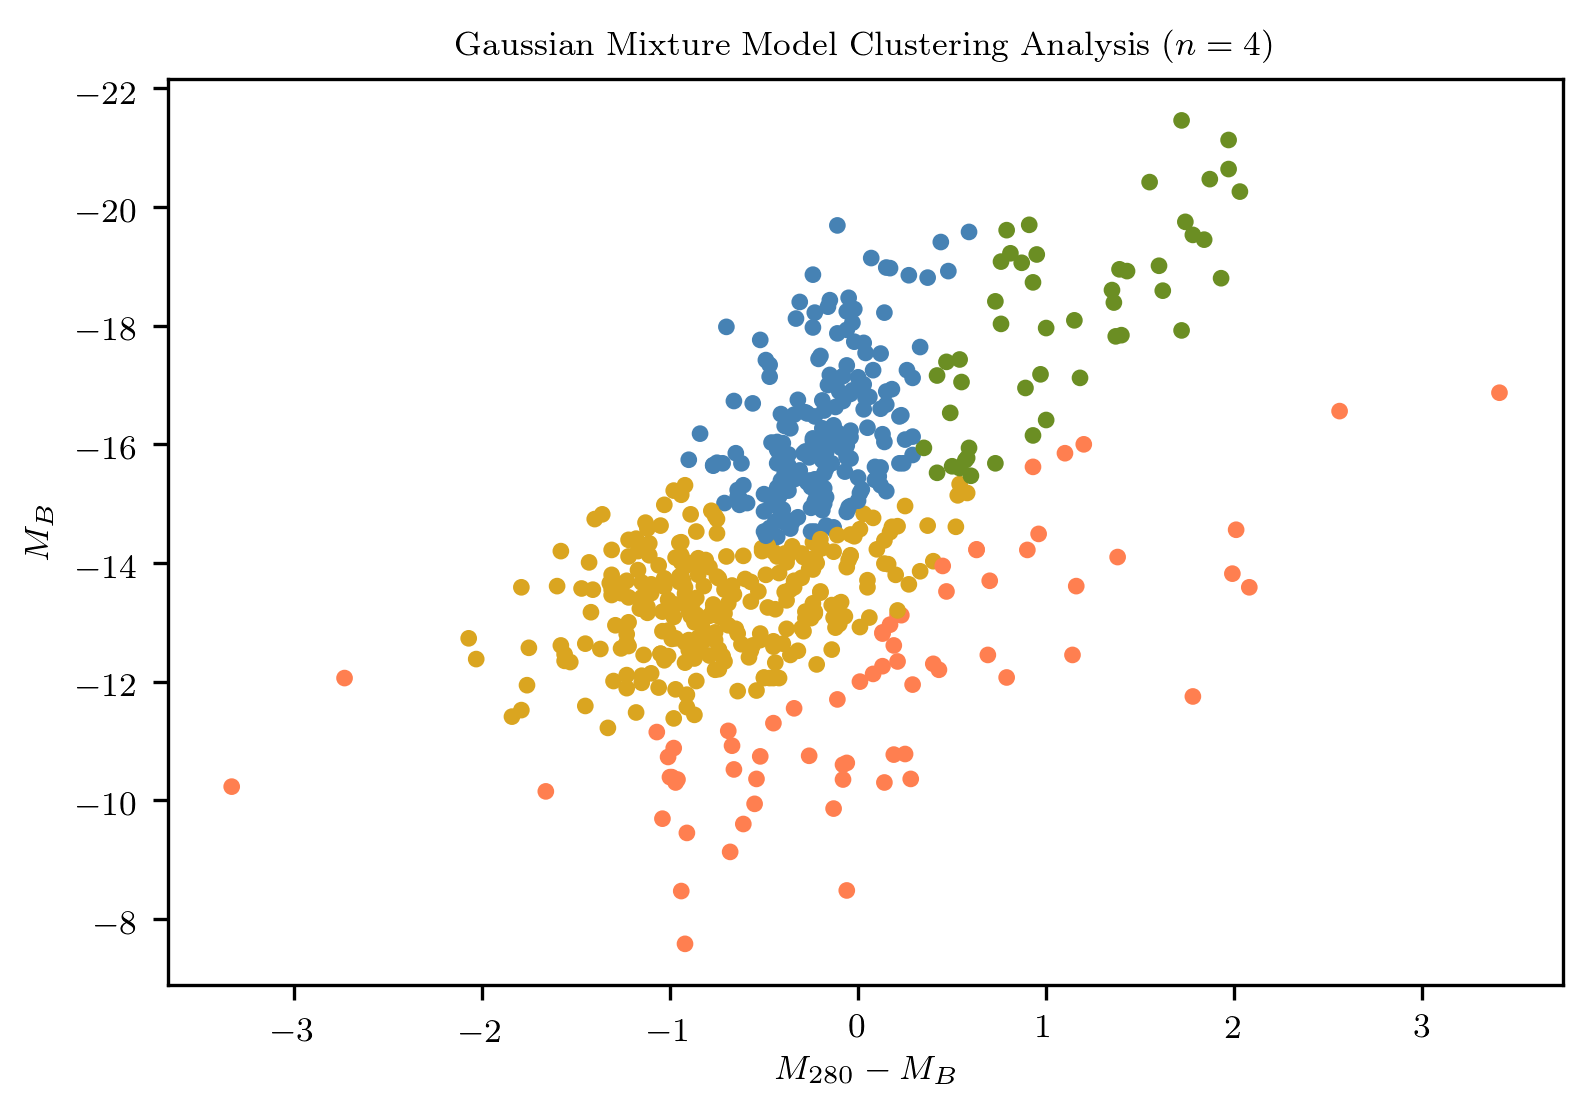

In [153]:
# Plot overlay of GMM and data

plt.figure(dpi = 300)
colors = [['coral', 'steelblue', 'goldenrod', 'olivedrab'][i - 1] for i in labels[3]]
plt.scatter(BV_Data, B_Data, c = colors, marker = '.')
plt.gca().invert_yaxis();
plt.title("Gaussian Mixture Model Clustering Analysis ($n = 4$)");
plt.ylabel("$M_B$");
plt.xlabel("$M_{280} - M_B$");

One thing that is very notacibly different between the GMM and the other types of clustering analysis which we've done on this data is that the GMM clusters are not *nearly* as stratified by $M_B$, while all the other clustering analysis have determined that the clusters lie in horizontal bands, more or less. To my eyes, it looks like this matches the clusters found in the KDE/KNN density plot most closely, which were definitely not stratifed horizontally. Perhaps this is a good indication that using these clustered Gaussians is a good model for observational data.